<div class="alert alert-info">

#### **MLP Experiment**

In this notebook we are going to train a simple linear classifier on the climbing dataset.

</div>

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
from experiments.helpers.plots_formatting import ICML

<div class="alert alert-info">

#### **1- Preliminary**

We first do a preliminary work to prepare the datasets. In order to know more about this, please read the `experiments/preliminary.ipynb` notebook.

</div>

In [24]:
from experiments.helpers.preliminary import preliminary, FilteringMode, FilteringOperator

In [25]:
# FILTERING_MODE = FilteringMode(0)
# FILTERING_MODE = FilteringMode.NO_PERSONLESS
# FILTERING_MODE = FilteringMode.NO_PERSONLESS | FilteringMode.NO_NOTHING_CLASS
FILTERING_MODE = FilteringMode.NO_PERSONLESS | FilteringMode.NO_NOTHING_CLASS | FilteringMode.NO_STOPWATCH_CLASS
# FILTERING_MODE = FilteringMode.NO_PERSONLESS | FilteringMode.NO_STOPWATCH_CLASS | FilteringMode.NO_NOTHING_CLASS | FilteringMode.NO_MULTI_CLASS

In [26]:
datasets, filtered_datasets, extractors = preliminary(
    filtering_mode=FILTERING_MODE,
    filtering_operator=FilteringOperator.OR,
    ignore_frames_extraction=True
)

[extractor-yolo]:
[extractor-dino]:
[extractor-r3d]:
[extractor-i3d]:
[extractor-clip]:
[extractor-x3d-xs]:
[extractor-x3d-s]:
[extractor-x3d-m]:
[extractor-x3d-l]:
[extractor-s3d-k]:
[extractor-s3d-h]:
[extractor-slowfast]:
[extractor-vivit]:


In [27]:
initial_size = len(datasets[0])
filtered_size = len(filtered_datasets[0])

reduction_percentage = 100 * (initial_size - filtered_size) / initial_size

print(f"[filtering-loss]: {reduction_percentage:.2f}%")

[filtering-loss]: 21.43%


<div class="alert alert-info">

#### **2- Model Creation**

Now we'll create the model on which we'll train the features we just extracted.

</div>

In [28]:
from bouldering_video_segmentation.models import VideoSegmentMlp

<div class="alert alert-info">

#### **3- Training**

Below we'll train our model on the different extracted features. We'll run several trainings with different feature extractors in order to do cross validation and have an accurate estimation of the model's performance.

The `Trainer` class is simply a class that takes the model and train it for a given number of epochs.

</div>

In [29]:
import torch

class WrapperDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        
    def __getitem__(self, index):
        if self.transform:
            return self.transform(self.dataset[index])
        else:
            return self.dataset[index]
        
    def __len__(self):
        return len(self.dataset)

In [30]:
def transform(sample):
    features, annotations, video_id, segment_index = sample
    
    return features, annotations[0]

In [31]:
NUMBER_OF_FOLDS = 5
NUMBER_ANNOTATED_VIDEOS = 22

from bouldering_video_segmentation.utils import LabelEncoderFactory

from experiments.helpers.trainer import Trainer, TrainerVariant
from experiments.helpers.splits_generator import splits_generator
from experiments.helpers.videos_to_indices import videos_to_indices

label_encoder = LabelEncoderFactory.get()

folds_histories: list[dict] = []

for fold_index, folds in enumerate(splits_generator(dataset_length=NUMBER_ANNOTATED_VIDEOS, k=NUMBER_OF_FOLDS)):
    histories = {}
    
    for dataset, extractor in zip(filtered_datasets, extractors):
        training_videos_ids, validation_videos_ids = folds
    
        # TODO: the issue is here, as the cached version is being used, some indices that have been filtered are trying to be reused
        training_samples_ids = videos_to_indices(dataset, training_videos_ids)
        validation_samples_ids = videos_to_indices(dataset, validation_videos_ids)
        
        training_dataset = WrapperDataset(torch.utils.data.Subset(dataset, training_samples_ids), transform)
        validation_dataset = WrapperDataset(torch.utils.data.Subset(dataset, validation_samples_ids), transform)
        
        training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)
        validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=False)
    
        linear_classifier = VideoSegmentMlp(input_size=training_dataset[0][0].shape[0], output_size=len(label_encoder.classes_))
        
        trainer = Trainer(model=linear_classifier, variant=TrainerVariant.MLP)
        
        statistics = trainer.train(training_dataloader, validation_dataloader, title=f"[training-{extractor.get_name()}-{fold_index + 1}/{NUMBER_OF_FOLDS}]")
        
        histories[extractor.get_name()] = statistics
        
    folds_histories.append(histories)

[training-vivit-5/5]: 100%|██████████| 32/32 [00:09<00:00,  3.51epoch/s, training-loss=0.203, training-accuracy=0.932, validation-loss=0.688, validation-accuracy=0.798, best-validation-accuracy=0.812, best-training-accuracy=0.819]


<div class="alert alert-info">

#### **4- Results**

Below we are going to display the training results for each model.

</div>

In [32]:
from experiments.helpers.training_results_visualization import aggregate_training_results

In [33]:
aggregated_training_results = aggregate_training_results(folds_histories)

models_training_accuracies = aggregated_training_results.models_training_accuracies
models_validation_accuracies = aggregated_training_results.models_validation_accuracies
models_training_losses = aggregated_training_results.models_training_losses
models_validation_losses = aggregated_training_results.models_validation_losses

In [34]:
import matplotlib.pyplot as plt

In [35]:
from experiments.helpers.training_results_visualization import Metric
from experiments.helpers.training_results_visualization import plot_models_performance, plot_models_comparison

<Figure size 1000x500 with 0 Axes>

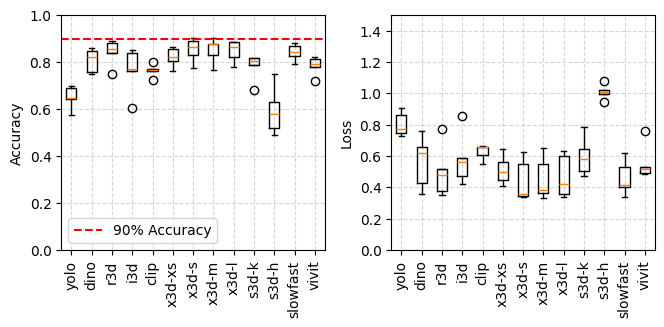

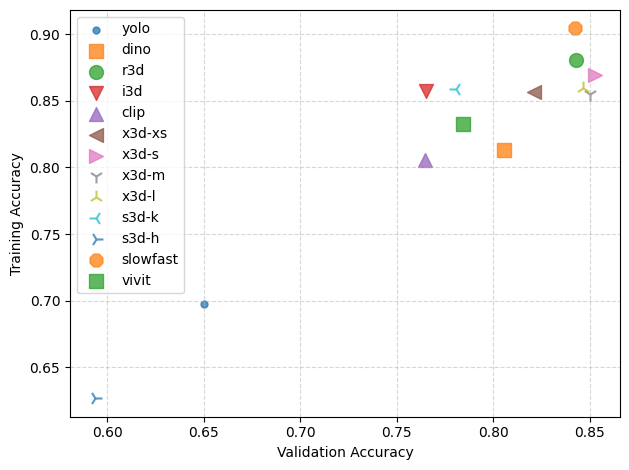

In [36]:
plot_models_performance(
    aggregated_training_results,
    Metric.ALL
)

plt.tight_layout()

plt.show()

plot_models_comparison(
    aggregated_training_results,
    Metric.ACCURACY
)

plt.tight_layout()

plt.show()

In [40]:
plot_models_performance(
    aggregated_training_results,
    Metric.ACCURACY
)

plt.tight_layout()

plt.savefig("../assets/figures/mlp.training-results.boxplot.png")

plt.close()

# --- --- --- ---- ---

plot_models_comparison(
    aggregated_training_results,
    Metric.ACCURACY
)

plt.tight_layout()

plt.savefig("../assets/figures/mlp.training-results.scatter.png")

plt.close()

<THIS IS A SEPARATION LINE> & <THIS IS A SEPARATION LINE> & <THIS IS A SEPARATION LINE> & <THIS IS A SEPARATION LINE> \\


<Figure size 1000x500 with 0 Axes>

In [43]:
from experiments.helpers.training_results_visualization import create_performance_table, write_latex_table

# --- --- --- ---

dataframe = create_performance_table(aggregated_training_results, extractors, latex=True)

dataframe['\#Parameters'] = [f"{extractor.get_number_of_params()}" for extractor in extractors]

write_latex_table(
    dataframe=dataframe,
    caption="MLP Models Performance Results.",
    path="../assets/tables/mlp.training-results.tex"
)

# --- --- --- ---

dataframe = create_performance_table(aggregated_training_results, extractors)

markdown_content = "# Pre-Trained Models\n\n"

dataframe['Type'] = [f"`{extractor.get_features_type()}`" for extractor in extractors]
dataframe['Model'] = [f"`MLP`" for extractor in extractors]
dataframe['Size'] = [f"{extractor.get_number_of_params()}" for extractor in extractors]
dataframe['Download Link'] = [f"[Download Weights](https://github.com/raideno/bouldering-video-segmentation/blob/main/models-weights/mlp.{extractor.get_name()}.pt)" for extractor in extractors]

markdown_table = dataframe.to_markdown(index=False)

markdown_content += markdown_table

with open("../models-weights/mlp.README.md", "w") as file:
    file.write(markdown_content)

<>:7: SyntaxWarning: invalid escape sequence '\#'
<>:7: SyntaxWarning: invalid escape sequence '\#'
/var/folders/hl/2fydtkj52y941xk_cs8nh5200000gn/T/ipykernel_39120/2122125682.py:7: SyntaxWarning: invalid escape sequence '\#'
  dataframe['\#Parameters'] = [f"{extractor.get_number_of_params()}" for extractor in extractors]


<div class="alert alert-info">

#### **5- Saving Models Weights**

Below we are going to save the models weights and results.

</div>

In [48]:
NUMBER_ANNOTATED_VIDEOS = 22

import itertools

from bouldering_video_segmentation.utils import LabelEncoderFactory

from experiments.helpers.trainer import Trainer
from experiments.helpers.splits_generator import splits_generator
from experiments.helpers.videos_to_indices import videos_to_indices
from experiments.helpers.training_results_visualization import get_best_performing_fold

label_encoder = LabelEncoderFactory.get()

# --- --- --- ---

fold_index = get_best_performing_fold(aggregated_training_results, Metric.ACCURACY)

folds = next(itertools.islice(splits_generator(dataset_length=NUMBER_ANNOTATED_VIDEOS, k=NUMBER_OF_FOLDS), fold_index, fold_index + 1))

training_videos_ids, validation_videos_ids = folds

stats = []

for dataset, extractor in zip(filtered_datasets, extractors):
    # TODO: the issue is here, as the cached version is being used, some indices that have been filtered are trying to be reused
    training_samples_ids = videos_to_indices(dataset, training_videos_ids)
    validation_samples_ids = videos_to_indices(dataset, validation_videos_ids)

    training_dataset = WrapperDataset(torch.utils.data.Subset(dataset, training_samples_ids), transform)
    validation_dataset = WrapperDataset(torch.utils.data.Subset(dataset, validation_samples_ids), transform)

    training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)
    validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=False)

    model = VideoSegmentMlp(input_size=training_dataset[0][0].shape[0], output_size=len(label_encoder.classes_))
    
    trainer = Trainer(model=model, variant=TrainerVariant.MLP)
    
    statistics = trainer.train(training_dataloader, validation_dataloader, title=f"[training-{extractor.get_name()}]")
    
    best_model_state_dict = statistics["best_model_state_dict"]
    
    stats.append(statistics["best_per_class_accuracy"])
    
    # torch.save(best_model_state_dict, f"../models-weights/mlp.{extractor.get_name()}.pt")

[training-vivit]: 100%|██████████| 32/32 [00:08<00:00,  3.95epoch/s, training-loss=0.247, training-accuracy=0.908, validation-loss=0.489, validation-accuracy=0.815, best-validation-accuracy=0.821, best-training-accuracy=0.889]


In [70]:
print(label_encoder.classes_)
print(label_encoder.transform(label_encoder.classes_))

index = 11

print(extractors[index].get_name(), stats[index])

['brossage' 'chrono' 'grimpe' 'lecture' 'nothing']
[0 1 2 3 4]
slowfast {0: 0.8181818181818182, 3: 0.8745980707395499, 2: 0.907563025210084}


In [78]:
for index, i in enumerate(stats):
    print(extractors[index].get_name(), len(i.keys()), i)

yolo 3 {0: 0.23737373737373738, 3: 0.8681672025723473, 2: 0.8025210084033614}
dino 3 {0: 0.6363636363636364, 3: 0.8681672025723473, 2: 0.9369747899159664}
r3d 3 {0: 0.797979797979798, 3: 0.8870967741935484, 2: 0.9372384937238494}
i3d 3 {0: 0.7171717171717171, 3: 0.8713826366559485, 2: 0.8865546218487395}
clip 4 {0: 0.7070707070707071, 3: 0.7508090614886731, 2: 0.7405857740585774, 4: 0.0}
x3d-xs 5 {0: 0.7222222222222222, 3: 0.8668831168831169, 2: 0.9372384937238494, 4: 0.0, 1: 0.0}
x3d-s 3 {0: 0.7828282828282829, 3: 0.9260450160771704, 2: 0.8991596638655462}
x3d-m 3 {0: 0.797979797979798, 3: 0.9035369774919614, 2: 0.9411764705882353}
x3d-l 3 {0: 0.803030303030303, 3: 0.909967845659164, 2: 0.9243697478991597}
s3d-k 3 {0: 0.7272727272727273, 3: 0.8135048231511254, 2: 0.8907563025210085}
s3d-h 3 {0: 0.0, 3: 0.6913183279742765, 2: 0.8991596638655462}
slowfast 3 {0: 0.8181818181818182, 3: 0.8745980707395499, 2: 0.907563025210084}
vivit 3 {0: 0.6868686868686869, 3: 0.8263665594855305, 2: 0.92